In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
import shap

# ML Libraries
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

# Imbalanced learning
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

In [2]:
CAT_COLS = ['type', 'subtype', 'size_category', 'temperature', 'above_median_access_count', 'above_median_filesize']
NUM_COLS = ['stddev_access_date',
 'dt_last_access_date',
 'dt_second_last_access_date',
 'dt_third_last_access_date',
 'dt_fourth_last_access_date',
 'dt_fifth_last_access_date',
 'normalized_access_count',
 'normalized_filesize',
 'access_count_last_1_day',
 'access_count_last_3_days',
 'access_count_last_7_days',
 'access_count_last_15_days',
 'lifetime',
 'access_count',
 'read_data_per_second']

In [3]:
df = pd.read_csv('/data/astro/scratch/msantama/tfm/data2.csv')

In [4]:
df.columns = [col.replace('x.', '') if col.startswith('x.') else col for col in df.columns]

In [5]:
# Each period rolls by 10 days, so, we will keep periods that are 20 days apart
df = df[df['period'].astype(int) % 2 == 0]
# We will predict for 20 days into the future, so we will drop the columns that are not needed
df.drop(columns=['y1', 'y3', 'pnfsid'], inplace=True)
# Reframe the periods to be again 0, 1, 2, ...
df['period'] = df['period'] // 2

In [6]:
df['m_date_window'] = pd.to_datetime(df['m_date_window'], format='%Y-%m-%d')
df = df[df['m_date_window'].dt.year < 2023]
df.drop(columns=['m_date_window'], inplace=True)

In [7]:
df[CAT_COLS] = df[CAT_COLS].astype(str)

In [8]:
class DtLastAccessesImputer(BaseEstimator, TransformerMixin):
    """ Custom imputer for the lasts accesses (except the last one).
    It will impute the Nan values with the value of the lifetime column and
    create a new flag column that indicates that the value was imputed.
    """
    def fit(self, X, y=None):
        self.cols = [
            'dt_second_last_access_date',
            'dt_third_last_access_date',
            'dt_fourth_last_access_date',
            'dt_fifth_last_access_date'
        ]
        self.flag_cols = [col + '_imputed' for col in self.cols]
        self.feature_names_ = list(X.columns) + self.flag_cols
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.cols:
            imputed_flag = X_transformed[col].isna().astype(int)
            X_transformed[col] = X_transformed[col].fillna(X_transformed['lifetime'])
            X_transformed[col + '_imputed'] = imputed_flag
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_)

In [ ]:
class RecencyRatio(BaseEstimator, TransofmerMixin):
    """ Creates a new column called recency ratio by dividing
    the lifetime witht the dt_last_access_date +1"""

In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import average_precision_score, roc_auc_score, precision_score, recall_score



# ---- Preprocessing pipeline ----
column_preprocessing = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CAT_COLS)
],remainder="passthrough")

preprocessor = Pipeline([
    ('imputer', DtLastAccessesImputer()),
    ('encoder', column_preprocessing),
    ('imputer2', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])



TRAINING_PERIODS = 6
MAXIMUM_PERIOD = np.max(df['period'])
TOP_K_RATIO = 0.2 

df_loop = df.copy()
results = []

for p in np.arange(TRAINING_PERIODS, MAXIMUM_PERIOD + 1):
    #---- 1. Split dataset ----
    df_seen = df_loop[df_loop['period'] < p].copy()
    df_unseen = df_loop[df_loop['period'] >= p].copy()

    # ---- 2. Undersample y=0 ----
    positive = df_seen[df_seen['y2'] == 1]
    negative = df_seen[df_seen['y2'] == 0]
    neg_sample = negative.sample(n=len(positive) * 2, random_state=42)
    df_train = pd.concat([positive, neg_sample])


    # ---- 3. Group by period with chunking for large groups ----
    X_parts = []
    y_parts = []
    group_sizes = []

    for period, group_df in df_train.groupby('period'):
        X_group = group_df.drop(columns=['y2'])
        y_group = group_df['y2']
    
        # Split large periods into chunks of max 5000 rows
        chunk_size = 5000
        for i in range(0, len(X_group), chunk_size):
            X_chunk = X_group.iloc[i:i+chunk_size]
            y_chunk = y_group.iloc[i:i+chunk_size]
            X_parts.append(X_chunk)
            y_parts.append(y_chunk)
            group_sizes.append(len(X_chunk))

    # Reconstruct full dataset
    X_train = pd.concat(X_parts, ignore_index=True)
    y_train = pd.concat(y_parts, ignore_index=True)

    X_train_transformed = preprocessor.fit_transform(X_train)

    # ---- 4. LightGBM Dataset with group ----
    lgb_train = lgb.Dataset(X_train_transformed, label=y_train)
    lgb_train.set_group(group_sizes)
    
    params = {
        'objective': 'lambdarank',
        'metric': 'map',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'class_weight': 'balanced'
    }
    
    model = lgb.train(params, lgb_train, num_boost_round=100)

    # Here I want to test for all the follwing unseen periods (ONE BY ONE!), maybe let's say 5 periods after this one (p).
    for p_test in np.arange(p, p+5):
        df_test = df_unseen[df_unseen['period'] == p_test]
        X_test = df_test.drop(columns=['y2'])
        y_test = df_test['y2']

        X_test_transformed = preprocessor.transform(X_test)
        y_pred = model.predict(X_test_transformed)

        #Test the results
        
        k = int(len(y_test) * TOP_K_RATIO)
        top_k_indices = np.argsort(y_pred)[::-1][:k]
        precision_at_k = y_test.iloc[top_k_indices].sum() / k
        recall_at_k = y_test.iloc[top_k_indices].sum() / y_test.sum() if y_test.sum() > 0 else 0.0
        map_score = average_precision_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) > 1 else float('nan')

        results.append({
            'train_period': p,
            'test_period': p_test,
            'precision@k': precision_at_k,
            'recall@k': recall_at_k,
            'map': map_score,
            'auc': auc_score,
            'k': k,
            'num_samples': len(y_test),
            'num_positives': y_test.sum()
        })
        print(p, p_test, precision_at_k, recall_at_k, map_score, auc_score, k, len(y_test), y_test.sum())

    # ---- 6. Drop the oldest period from the loop ----
    df_loop = df_loop[df_loop['period'] > df_loop['period'].min()]
        





6 6 0.11195237170775901 0.13119975731836797 0.1583385533013717 0.48601755971647 46359 231796 39558
6 7 0.1927760389298851 0.1852917279694328 0.18967965200373768 0.4538962462752284 43771 218859 45539
6 8 0.1433925948437421 0.12288126397117868 0.17968677435501496 0.37199149132472864 39486 197431 46077
6 9 0.1338779041657124 0.12061534228988033 0.1844223304717177 0.4251890620403422 39297 196485 43618
6 10 0.08248987854251012 0.09380215227024227 0.14017533579988764 0.413967907759029 39520 197604 34754
7 7 0.4718649334033949 0.4535453128088012 0.4423380204476844 0.6947064870663936 43771 218859 45539
7 8 0.5077242566985767 0.4350977711222519 0.509723222696257 0.7270740372820778 39486 197431 46077
7 9 0.38913912003460827 0.3505892062909808 0.370981349235693 0.684735022253913 39297 196485 43618
7 10 0.4189524291497976 0.4764055936007366 0.39396470804525685 0.662232010844271 39520 197604 34754
7 11 0.2168570285765077 0.3034137545081457 0.2383849862660014 0.6414819801369935 45002 225014 32164
8 

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [16]:
results_df = pd.DataFrame(results)
next_period_eval = results_df[results_df['train_period'] == results_df['test_period']]
next_period_eval

,train_period,test_period,precision@k,recall@k,map,auc,k,num_samples,num_positives
0,6,6,0.111952,0.131200,0.158339,0.486018,46359,231796,39558
5,7,7,0.471865,0.453545,0.442338,0.694706,43771,218859,45539
10,8,8,0.460847,0.394926,0.418398,0.716977,39486,197431,46077
15,9,9,0.525689,0.473612,0.461764,0.747264,39297,196485,43618
20,10,10,0.472495,0.537291,0.453531,0.765290,39520,197604,34754
25,11,11,0.129616,0.181352,0.138336,0.465729,45002,225014,32164
30,12,12,0.273025,0.404568,0.260038,0.609374,54431,272156,36733
35,13,13,0.153057,0.472659,0.121166,0.701880,52464,262323,16989
40,14,14,0.186392,0.531276,0.290235,0.739191,54954,274773,19280
45,15,15,0.207338,0.483244,0.339073,0.772368,36930,184650,15845


In [17]:
df

,type,subtype,stddev_access_date,dt_last_access_date,dt_second_last_access_date,dt_third_last_access_date,dt_fourth_last_access_date,dt_fifth_last_access_date,normalized_access_count,normalized_filesize,...,above_median_filesize,access_count_last_1_day,access_count_last_3_days,access_count_last_7_days,access_count_last_15_days,lifetime,access_count,read_data_per_second,y2,period
0,mc,AODSIM,82247.999611,2140878,2305374.0,NaN,NaN,NaN,0.009615,0.266822,...,0,0,0,0,0,2305374,2,3514.301757,0,0
1,data,MINIAOD,0.000000,4207853,NaN,NaN,NaN,NaN,0.015094,0.529322,...,0,0,0,0,0,15685966,5,0.000000,0,0
2,mc,GEN-SIM-RAW,0.000000,806276,NaN,NaN,NaN,NaN,0.009225,0.277707,...,1,0,0,0,1,23237127,6,78.456712,1,0
3,data,RAW-RECO,0.000000,4207606,NaN,NaN,NaN,NaN,0.166667,0.239712,...,0,0,0,0,0,24996137,3,0.000000,1,0
4,data,RAW,0.000000,175846,NaN,NaN,NaN,NaN,0.000000,0.380273,...,1,0,1,1,1,175846,1,23334.819245,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16745214,mc,MINIAODSIM,305190.500927,2856097,3466478.0,NaN,NaN,NaN,0.005263,0.010454,...,0,0,0,0,0,3466478,2,106.296880,0,33
16745215,mc,MINIAODSIM,0.000000,5504142,NaN,NaN,NaN,NaN,0.000000,0.148908,...,1,0,0,0,0,5504142,1,234.859633,0,33
16745216,mc,AODSIM,0.000000,4541828,NaN,NaN,NaN,NaN,0.000000,0.247098,...,0,0,0,0,0,4541828,1,979.549493,0,33
16745217,mc,AODSIM,0.000000,4528037,NaN,NaN,NaN,NaN,0.000000,0.472891,...,1,0,0,0,0,4528037,1,1880.351937,0,33


In [22]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

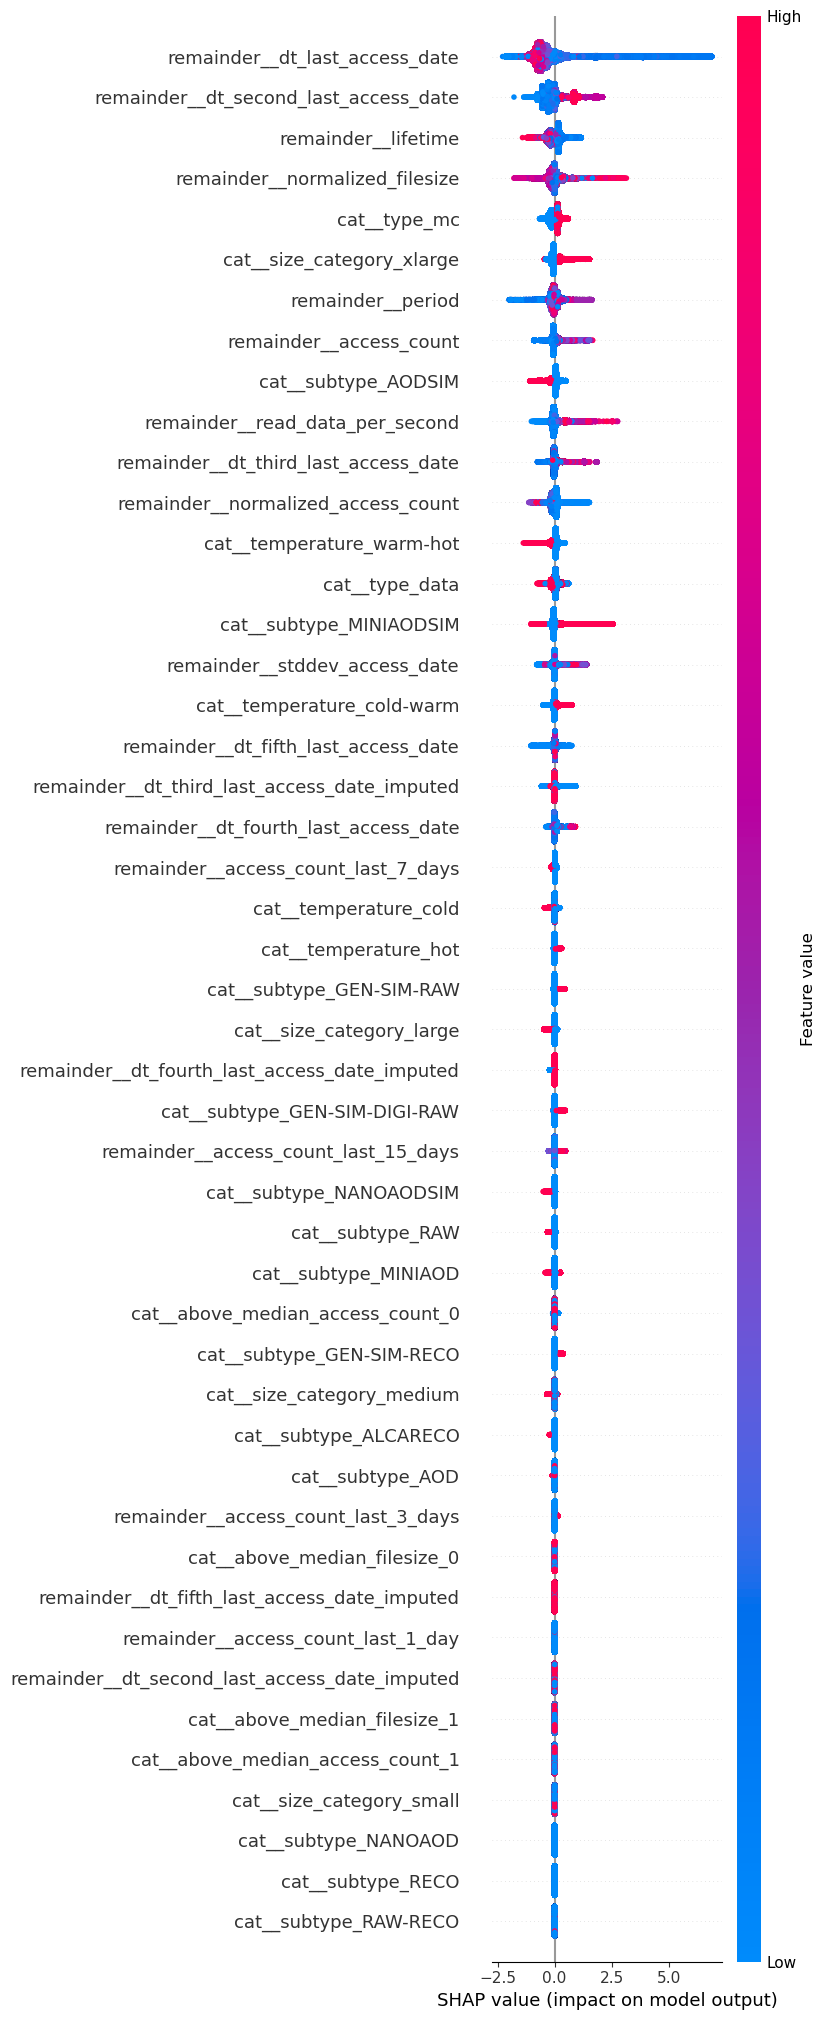

In [23]:
# Summary plot (aggregated importance)
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, max_display=100)

In [24]:
feature_names

array(['cat__type_data', 'cat__type_mc', 'cat__subtype_ALCARECO',
       'cat__subtype_AOD', 'cat__subtype_AODSIM',
       'cat__subtype_GEN-SIM-DIGI-RAW', 'cat__subtype_GEN-SIM-RAW',
       'cat__subtype_GEN-SIM-RECO', 'cat__subtype_MINIAOD',
       'cat__subtype_MINIAODSIM', 'cat__subtype_NANOAOD',
       'cat__subtype_NANOAODSIM', 'cat__subtype_RAW',
       'cat__subtype_RAW-RECO', 'cat__subtype_RECO',
       'cat__size_category_large', 'cat__size_category_medium',
       'cat__size_category_small', 'cat__size_category_xlarge',
       'cat__temperature_cold', 'cat__temperature_cold-warm',
       'cat__temperature_hot', 'cat__temperature_warm-hot',
       'cat__above_median_access_count_0',
       'cat__above_median_access_count_1', 'cat__above_median_filesize_0',
       'cat__above_median_filesize_1', 'remainder__stddev_access_date',
       'remainder__dt_last_access_date',
       'remainder__dt_second_last_access_date',
       'remainder__dt_third_last_access_date',
       'remaind